In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict
from sklearn import metrics
import operator

* Load the training data and add ‘is_swing’ by parsing the data in ‘pitch_call’

In [ ]:
data = pd.read_csv('2021-train.csv')
data['is_swing'] = np.where(data.pitch_call.isin(['FoulBall', 'InPlay', 'StrikeSwinging']), 1, 0)

* Add engineered features, such as the distance of the pitch from the center of the zone, the location of the pitch without any break, and boolean columns for bucketing the location and count.

    * The xgboost models perform better when the target can be largely explained by a monotonic dependence on just a few features.
    
    * I chose an xgboost model because it is particularly well suited to highly nonlinear problems with many interactions and access to a large dataset.


In [2]:
data['horz_break_flip'] = np.where(data.pitcher_side == 'Left', data.horz_break*-1, data.horz_break)
data['plate_side_flip'] = np.where(data.batter_side == 'Left', data.plate_side*-1, data.plate_side)
data['dist_from_center'] = np.sqrt(data.plate_side**2+(data.plate_height-2.5)**2)
data['pitch_group'] = np.where(data.pitch_type.isin(['FA', 'SI']), 'FAST', 'SEC')
data['no_break_side'] = data.plate_side - data.horz_break/12
data['no_break_height'] = data.plate_height - data.induced_vert_break/12
data['no_break_dist'] = np.sqrt(data.no_break_side**2+(data.no_break_height-2.5)**2)
data['first_pitch'] = np.where((data.balls == 0) & (data.strikes == 0), 1, 0)
data['full_count'] = np.where(data.balls+data.strikes == 5, 1, 0)
data['two_k'] = np.where((data.balls < 3) & (data.strikes == 2), 1, 0)
data['hit_count'] = np.where(data.balls-data.strikes == 2, 1, 0)
data['three_oh'] = np.where(data.balls-data.strikes == 3, 1, 0)
data['even'] = np.where((abs(data.balls-data.strikes) < 2) & (abs(data.balls+data.strikes-2) < 2) & (data.strikes < 2), 1, 0)
data['up'] = np.where(data.plate_height > 3, 1, 0)
data['down'] = np.where(data.plate_height < 2, 1, 0)
data['out'] = np.where(data.plate_side_flip > 0.5, 1, 0)
data['in'] = np.where(data.plate_side_flip < -.5, 1, 0)
data['middle'] = np.where((abs(data.plate_height-2.5) < 0.5) & (abs(data.plate_side) < 0.5), 1, 0)
data = pd.get_dummies(data, columns=['level'])

* Split the training data into a training set and a validation set

In [3]:
df, val = train_test_split(data, test_size = 0.2)

* Set the features that will be used in the pitch characteristic-only model, including monotonic constraints on ‘dist_from_center’ and ‘no_break_dist’ which are the distance from the center of the zone with and without break respectively.
* More features were tested than shown in the notebook. Other than the features describing the count and pitch location, the next few most important features for both fastball and secondary offerings were included in the final model.


In [5]:
predictors = ['balls', 'strikes', 'vert_release_angle', 'horz_release_angle', 'spin_rate', 'extension', 'dist_from_center',
              'no_break_side', 'no_break_height', 'plate_height', 'plate_side', 'horz_approach_angle', 'no_break_dist']

target = 'is_swing'

mtc = (0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 -1)

* Tune the hyperparameters of the pitch characteristics-only xgboost models using cross-validation on the training set.
* There are 8 separate models trained, one for each combination of fastball/secondary and matchup platoon.
* The cross validation was done using R vs R fastballs, and I confirmed that the optimal values were reasonable for the other models.
* A variety of different parameter grids were used during tuning; a final example grid is shown in the notebook.

In [8]:
for pitch_group in ['FAST']:
    for pitcher_side in ['Right']:
        for batter_side in ['Right']:
            d = df.loc[(df.pitch_group == pitch_group) & (df.pitcher_side == pitcher_side) & (df.batter_side == batter_side)]

            xgb_temp = XGBClassifier(
             learning_rate = 0.1,
             n_estimators=110,
             max_depth=7,
             min_child_weight=32,
             gamma=1,
             subsample=1,
             colsample_bytree=1,
             reg_alpha=0.5,
             reg_lambda=0.2,
             objective= 'binary:logistic',
             nthread=1,
             scale_pos_weight=1,
             monotone_constraints = mtc,
             seed=27)

            param_grid = {
                'min_child_weight': [16,32], 'gamma': [1,2], 'max_depth':[6,7]
            }

            clf = GridSearchCV(xgb_temp, param_grid, scoring='neg_log_loss', cv=5, n_jobs=10, return_train_score = True)

            clf.fit(d[predictors], d[target])

            res = pd.DataFrame(clf.cv_results_)

In [9]:
res[['param_gamma', 'param_max_depth', 'param_min_child_weight', 'mean_test_score', 'rank_test_score']]

,param_gamma,param_max_depth,param_min_child_weight,mean_test_score,rank_test_score
0,1,6,16,-0.437135,6
1,1,6,32,-0.437159,7
2,1,7,16,-0.437077,4
3,1,7,32,-0.436960,1
4,2,6,16,-0.437019,3
5,2,6,32,-0.437248,8
6,2,7,16,-0.437000,2
7,2,7,32,-0.437080,5


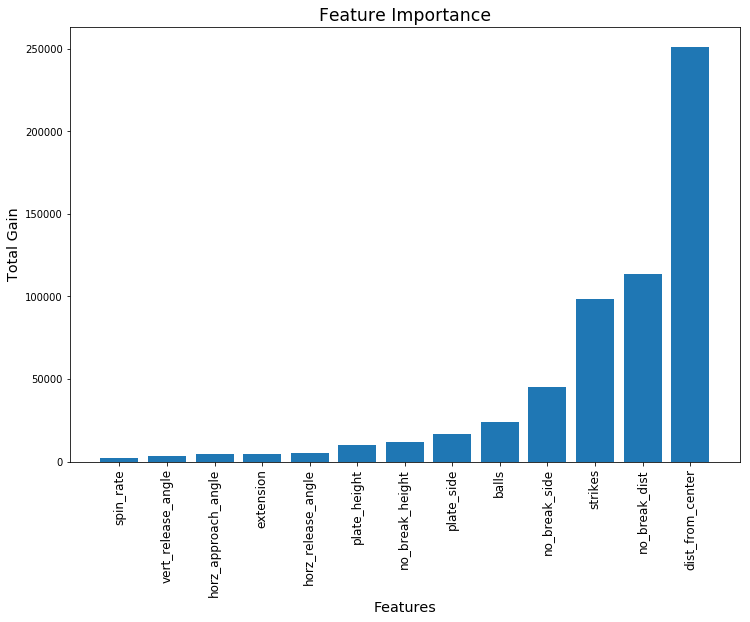

In [10]:
f = clf.best_estimator_.get_booster().get_score(importance_type = 'total_gain')
sorted_f = sorted(f.items(), key=operator.itemgetter(1))
x, y = zip(*sorted_f)
plt.figure(figsize=(12,8))
plt.bar(x,y)
plt.xticks(x, rotation='vertical',size='large')
plt.xlabel('Features', size='x-large')
plt.ylabel('Total Gain', size='x-large')
plt.title('Feature Importance', size='xx-large')
plt.show()

In [11]:
def get_adj_var(values, weights, var):
    return np.average(np.where(weights > 0, (values)**2-var/(weights+1), 0), weights = weights)

*	Calculate the average difference between a batter’s swing rate and the expected swing rate based on the pitch characteristics-only models for different counts and pitch locations. The difference is calculated separately for each platoon and pitch group. We’ll call these numbers a batter’s “swing peripherals” from now on.
*	The count buckets were chosen based on when hitters may significantly change their approach
    *	First Pitch (0-0)
    *	Even (1-0, 0-1, 1-1, 2-1)
    *	Three Balls No Strikes (3-0)
    *	Hitter’s Count (2-0, 3-1)
    *	Two Strikes (0-2, 1-2, 2-2)
    *	Full Count (3-2)
*	The pitch location buckets are
    * Up (> 6 inches above the center of the zone)
    * Down (> 6 inches below the center of the zone)
    * Inside (> 6 inches towards the hitter from the center of the zone)
    * Outside (> 6 inches away from the hitter from the center of the zone)
    * Middle (within the central 1 square foot of the strike zone)
*	Regress the swing peripherals to account for sample size differences. The proper regression amount is estimated from the ratio of the variance of the differences themselves to the variance of the average difference of the hitters, adjusted and weighting for sample size

In [12]:
batters = {}
for pitch_group in ['FAST', 'SEC']:
    for pitcher_side in ['Left', 'Right']:
        for batter_side in ['Left', 'Right']:
            key = (pitch_group, pitcher_side, batter_side)
            print(key)
            d = df.loc[(df.pitch_group == pitch_group) & (df.pitcher_side == pitcher_side) & (df.batter_side == batter_side)].copy()

            xgb_temp = XGBClassifier(
                 learning_rate = 0.05,
                 n_estimators=220,
                 max_depth=7,
                 min_child_weight=32,
                 gamma=1,
                 subsample=1,
                 colsample_bytree=1,
                 reg_alpha=0.5,
                 reg_lambda=0.2,
                 objective= 'binary:logistic',
                 nthread=2,
                 scale_pos_weight=1,
                 monotone_constraints = mtc,
                 seed=27)

            d['swing_prob'] = cross_val_predict(xgb_temp, d[predictors], d[target], cv=5,
                                                n_jobs=10, verbose = 0, method = 'predict_proba')[:,1]

            d['swing_prob_diff'] = d.is_swing-d.swing_prob

            batters[key] = pd.DataFrame(d.batter_id.drop_duplicates())
            batters[key].columns = ['batter_id']

            for split in ['first_pitch', 'full_count', 'two_k', 'hit_count', 'three_oh', 'even',
                          'up', 'down', 'out', 'in', 'middle']:

                diff = d.loc[d[split] == 1, ['batter_id', 'swing_prob_diff']].groupby(by=['batter_id']).mean().reset_index()
                n = d.loc[d[split] == 1, ['batter_id', 'pitch_id']].groupby(by=['batter_id']).count().reset_index()
                diff = diff.merge(n)

                var = np.var(d.loc[d[split] == 1, ['swing_prob_diff']]).values[0]
                adj_var = get_adj_var(diff.swing_prob_diff, diff.pitch_id, var)
                reg = var/adj_var
                if adj_var < 0 or reg > 40:
                    reg = 40

                diff['swing_prob_diff'] *= diff.pitch_id/(diff.pitch_id+reg)
                diff = diff.drop(columns = ['pitch_id'])
                diff.columns = ['batter_id', split]

                batters[key] = batters[key].merge(diff, how='left')
            print()

('FAST', 'Left', 'Left')

('FAST', 'Left', 'Right')

('FAST', 'Right', 'Left')

('FAST', 'Right', 'Right')

('SEC', 'Left', 'Left')

('SEC', 'Left', 'Right')

('SEC', 'Right', 'Left')

('SEC', 'Right', 'Right')



* Include the regressed batter swing peripherals as features in the final xgboost model.
* The features corresponding to the count and x- and y- location of the pitch are given their own features. This is mostly what the model focuses on, but all the swing peripherals are provided for context.
* Monotonic constraints are placed on all of the swing peripheral features to prevent overfitting. Basically, if a swing peripheral is high, then the model can only use that information to increase the probability of swing, never decrease it.
* This is the step where I planned on including the level as a feature. It was important not to include it in the pitch characteristic-only model, as that would make the swing peripherals relative to the level, and I wanted them to all be on the same scale. However, when I included one-hot encoded features for the level, they were by far the least significant features in the model. It appears that the batter swing peripherals were sufficient to encode the differences in swing-decision talent that exists across levels.


In [13]:
old_predictors = predictors
predictors = old_predictors + ['first_pitch', 'full_count', 'two_k', 'hit_count', 'three_oh', 'even',
                               'up', 'down', 'out', 'in', 'middle', 'x_bucket', 'y_bucket', 'count_bucket']

new_mtc = (0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1)

xgb_olds = {}
xgb_news = {}
for pitch_group in ['FAST', 'SEC']:
    for pitcher_side in ['Left', 'Right']:
        for batter_side in ['Left', 'Right']:
            key = (pitch_group, pitcher_side, batter_side)
            print(key)
            d = df.loc[(df.pitch_group == pitch_group) & (df.pitcher_side == pitcher_side) & (df.batter_side == batter_side)].copy()

            d = d[old_predictors + [target] + ['batter_id']].merge(batters[key], how='left')

            if batter_side == 'Left':
                d['plate_side_flip'] = d.plate_side*-1
            else:
                d['plate_side_flip'] = d.plate_side

            d['x_bucket'] = np.where(d.plate_side_flip > 0.5, d.out, np.where(d.plate_side_flip < -0.5, d['in'], d.middle))
            d['y_bucket'] = np.where(d.plate_height > 3, d.up, np.where(d.plate_height < 2, d.down, d.middle))
            d['count_bucket'] = np.where((d.balls == 0) & (d.strikes == 0), d.first_pitch, 
                                        np.where(d.balls+d.strikes == 5, d.full_count, 
                                                 np.where((d.balls < 3) & (d.strikes == 2), d.two_k,
                                                           np.where(d.balls-d.strikes == 2, d.hit_count, 
                                                                    np.where(d.balls-d.strikes == 3, d.three_oh, 
                                                                             d.even)))))

            d = d.fillna(0)

            xgb_old = XGBClassifier(
                 learning_rate = 0.1,
                 n_estimators=110,
                 max_depth=7,
                 min_child_weight=32,
                 gamma=1,
                 subsample=1,
                 colsample_bytree=1,
                 reg_alpha=0.5,
                 reg_lambda=0.2,
                 monotone_constraints = mtc,
                 objective= 'binary:logistic',
                 nthread=10,
                 scale_pos_weight=1,
                 seed=27)

            xgb_old.fit(d[old_predictors], d[target])
            
            xgb_new = XGBClassifier(
                 learning_rate = 0.1,
                 n_estimators=110,
                 max_depth=7,
                 min_child_weight=16,
                 gamma=1,
                 subsample=1,
                 colsample_bytree=1,
                 reg_alpha=0.5,
                 reg_lambda=0.2,
                 monotone_constraints = new_mtc,
                 objective= 'binary:logistic',
                 nthread=10,
                 scale_pos_weight=1,
                 seed=27)

            xgb_new.fit(d[predictors], d[target])
            
            t = val.loc[(val.pitch_group == pitch_group) & (val.pitcher_side == pitcher_side) 
                        & (val.batter_side == batter_side)].copy()
            
            t = t[old_predictors + [target] + ['batter_id']].merge(batters[key], how='left')

            if batter_side == 'Left':
                t['plate_side_flip'] = t.plate_side*-1
            else:
                t['plate_side_flip'] = t.plate_side

            t['x_bucket'] = np.where(t.plate_side_flip > 0.5, t.out, np.where(t.plate_side_flip < -0.5, t['in'], t.middle))
            t['y_bucket'] = np.where(t.plate_height > 3, t.up, np.where(t.plate_height < 2, t.down, t.middle))
            t['count_bucket'] = np.where((t.balls == 0) & (t.strikes == 0), t.first_pitch, 
                                        np.where(t.balls+t.strikes == 5, t.full_count, 
                                                 np.where((t.balls < 3) & (t.strikes == 2), t.two_k,
                                                           np.where(t.balls-t.strikes == 2, t.hit_count, 
                                                                    np.where(t.balls-t.strikes == 3, t.three_oh, 
                                                                             t.even)))))
            y_pred = xgb_old.predict_proba(t[old_predictors])[:,1]*0.25+xgb_new.predict_proba(t[predictors])[:,1]*0.75
            y_pred = np.where(y_pred > 0.5, 1, 0)
            print(metrics.accuracy_score(t.is_swing, y_pred))

* Tune the hyperparameters for the final xgboost models by maximizing accuracy on the held-out validation set across all 8 models.
* Because the swing peripherals are not out-of-sample for the training set, there is a tendency for them to overfit even with the monotonic constraints. I found that the most accurate results could be obtained by weighting the final model that includes swing peripherals at 75% and the original pitch characteristic-only model at 25%.

In [16]:
predictors = ['balls', 'strikes', 'vert_release_angle', 'horz_release_angle', 'spin_rate', 'extension', 'dist_from_center',
              'no_break_side', 'no_break_height', 'plate_height', 'plate_side', 'horz_approach_angle', 'no_break_dist']

batters = {}
for pitch_group in ['FAST', 'SEC']:
    for pitcher_side in ['Left', 'Right']:
        for batter_side in ['Left', 'Right']:
            key = (pitch_group, pitcher_side, batter_side)
            print(key)
            d = data.loc[(data.pitch_group == pitch_group) & (data.pitcher_side == pitcher_side) & (data.batter_side == batter_side)].copy()

            xgb_temp = XGBClassifier(
                 learning_rate = 0.05,
                 n_estimators=220,
                 max_depth=7,
                 min_child_weight=32,
                 gamma=1,
                 subsample=1,
                 colsample_bytree=1,
                 reg_alpha=0.5,
                 reg_lambda=0.2,
                 monotone_constraints=mtc,
                 objective= 'binary:logistic',
                 nthread=2,
                 scale_pos_weight=1,
                 seed=27)

            d['swing_prob'] = cross_val_predict(xgb_temp, d[predictors], d[target], cv=5,
                                                n_jobs=10, verbose = 0, method = 'predict_proba')[:,1]

            d['swing_prob_diff'] = d.is_swing-d.swing_prob

            batters[key] = pd.DataFrame(d.batter_id.drop_duplicates())
            batters[key].columns = ['batter_id']

            for split in ['first_pitch', 'full_count', 'two_k', 'hit_count', 'three_oh', 'even',
                          'up', 'down', 'out', 'in', 'middle']:

                diff = d.loc[d[split] == 1, ['batter_id', 'swing_prob_diff']].groupby(by=['batter_id']).mean().reset_index()
                n = d.loc[d[split] == 1, ['batter_id', 'pitch_id']].groupby(by=['batter_id']).count().reset_index()
                diff = diff.merge(n)

                var = np.var(d.loc[d[split] == 1, ['swing_prob_diff']]).values[0]
                adj_var = get_adj_var(diff.swing_prob_diff, diff.pitch_id, var)
                reg = var/adj_var
                if adj_var < 0 or reg > 40:
                    reg = 40

                diff['swing_prob_diff'] *= diff.pitch_id/(diff.pitch_id+reg)
                diff = diff.drop(columns = ['pitch_id'])
                diff.columns = ['batter_id', split]

                batters[key] = batters[key].merge(diff, how='left')
            print()

In [18]:
old_predictors = predictors
predictors = old_predictors + ['first_pitch', 'full_count', 'two_k', 'hit_count', 'three_oh', 'even',
                               'up', 'down', 'out', 'in', 'middle', 'x_bucket', 'y_bucket', 'count_bucket']

* Retrain all models using the entire training set.

In [19]:
xgb_olds = {}
xgb_news = {}
for pitch_group in ['FAST', 'SEC']:
    for pitcher_side in ['Left', 'Right']:
        for batter_side in ['Left', 'Right']:
            key = (pitch_group, pitcher_side, batter_side)
            print(key)
            d = data.loc[(data.pitch_group == pitch_group) & (data.pitcher_side == pitcher_side) & (data.batter_side == batter_side)].copy()

            d = d[old_predictors + [target] + ['batter_id']].merge(batters[key], how='left')

            if batter_side == 'Left':
                d['plate_side_flip'] = d.plate_side*-1
            else:
                d['plate_side_flip'] = d.plate_side

            d['x_bucket'] = np.where(d.plate_side_flip > 0.5, d.out, np.where(d.plate_side_flip < -0.5, d['in'], d.middle))
            d['y_bucket'] = np.where(d.plate_height > 3, d.up, np.where(d.plate_height < 2, d.down, d.middle))
            d['count_bucket'] = np.where((d.balls == 0) & (d.strikes == 0), d.first_pitch, 
                                        np.where(d.balls+d.strikes == 5, d.full_count, 
                                                 np.where((d.balls < 3) & (d.strikes == 2), d.two_k,
                                                           np.where(d.balls-d.strikes == 2, d.hit_count, 
                                                                    np.where(d.balls-d.strikes == 3, d.three_oh, 
                                                                             d.even)))))

            d = d.fillna(0)

            xgb_old = XGBClassifier(
                 learning_rate = 0.01,
                 n_estimators=1000,
                 max_depth=7,
                 min_child_weight=32,
                 gamma=1,
                 subsample=1,
                 colsample_bytree=1,
                 reg_alpha=0.5,
                 reg_lambda=0.2,
                 monotone_constraints=mtc,
                 objective= 'binary:logistic',
                 nthread=10,
                 scale_pos_weight=1,
                 seed=27)

            xgb_old.fit(d[old_predictors], d[target])
            
            xgb_new = XGBClassifier(
                 learning_rate = 0.01,
                 n_estimators=1000,
                 max_depth=7,
                 min_child_weight=16,
                 gamma=1,
                 subsample=1,
                 colsample_bytree=1,
                 reg_alpha=0.5,
                 reg_lambda=0.2,
                 monotone_constraints = new_mtc,
                 objective= 'binary:logistic',
                 nthread=10,
                 scale_pos_weight=1,
                 seed=27)

            xgb_new.fit(d[predictors], d[target])
            
            xgb_olds[key] = xgb_old
            xgb_news[key] = xgb_new

('FAST', 'Left', 'Left')
('FAST', 'Left', 'Right')
('FAST', 'Right', 'Left')
('FAST', 'Right', 'Right')
('SEC', 'Left', 'Left')
('SEC', 'Left', 'Right')
('SEC', 'Right', 'Left')
('SEC', 'Right', 'Right')


*	Load the test set and add all engineered features, including joining in the swing peripherals.

In [20]:
test = pd.read_csv('2021-test.csv')
test['horz_break_flip'] = np.where(test.pitcher_side == 'Left', test.horz_break*-1, test.horz_break)
test['plate_side_flip'] = np.where(test.batter_side == 'Left', test.plate_side*-1, test.plate_side)
test['dist_from_center'] = np.sqrt(test.plate_side**2+(test.plate_height-2.5)**2)
test['pitch_group'] = np.where(test.pitch_type.isin(['FA', 'SI']), 'FAST', 'SEC')
test['no_break_side'] = test.plate_side - test.horz_break/12
test['no_break_height'] = test.plate_height - test.induced_vert_break/12
test['no_break_dist'] = np.sqrt(test.no_break_side**2+(test.no_break_height-2.5)**2)
test['first_pitch'] = np.where((test.balls == 0) & (test.strikes == 0), 1, 0)
test['full_count'] = np.where(test.balls+test.strikes == 5, 1, 0)
test['two_k'] = np.where((test.balls < 3) & (test.strikes == 2), 1, 0)
test['hit_count'] = np.where(test.balls-test.strikes == 2, 1, 0)
test['three_oh'] = np.where(test.balls-test.strikes == 3, 1, 0)
test['even'] = np.where((abs(test.balls-test.strikes) < 2) & (abs(test.balls+test.strikes-2) < 2) & (test.strikes < 2), 1, 0)
test['up'] = np.where(test.plate_height > 3, 1, 0)
test['down'] = np.where(test.plate_height < 2, 1, 0)
test['out'] = np.where(test.plate_side_flip > 0.5, 1, 0)
test['in'] = np.where(test.plate_side_flip < -.5, 1, 0)
test['middle'] = np.where((abs(test.plate_height-2.5) < 0.5) & (abs(test.plate_side) < 0.5), 1, 0)
test = pd.get_dummies(test, columns=['level'])

*	Predict whether the batter swung at each pitch in the test set using a 75/25 split of the swing peripheral-inclusive and pitch characteristic-only models.

In [21]:
res = {}
for pitch_group in ['FAST', 'SEC']:
    for pitcher_side in ['Left', 'Right']:
        for batter_side in ['Left', 'Right']:
            key = (pitch_group, pitcher_side, batter_side)
            print(key)
            d = test.loc[(test.pitch_group == pitch_group) & (test.pitcher_side == pitcher_side) & (test.batter_side == batter_side)].copy()

            d = d[old_predictors + [target] + ['batter_id']+['pitch_id']].merge(batters[key], how='left')

            if batter_side == 'Left':
                d['plate_side_flip'] = d.plate_side*-1
            else:
                d['plate_side_flip'] = d.plate_side

            d['x_bucket'] = np.where(d.plate_side_flip > 0.5, d.out, np.where(d.plate_side_flip < -0.5, d['in'], d.middle))
            d['y_bucket'] = np.where(d.plate_height > 3, d.up, np.where(d.plate_height < 2, d.down, d.middle))
            d['count_bucket'] = np.where((d.balls == 0) & (d.strikes == 0), d.first_pitch, 
                                        np.where(d.balls+d.strikes == 5, d.full_count, 
                                                 np.where((d.balls < 3) & (d.strikes == 2), d.two_k,
                                                           np.where(d.balls-d.strikes == 2, d.hit_count, 
                                                                    np.where(d.balls-d.strikes == 3, d.three_oh, 
                                                                             d.even)))))

            d = d.fillna(0)
            
            y_pred = xgb_olds[key].predict_proba(d[old_predictors])[:,1]*.25+\
                     xgb_news[key].predict_proba(d[predictors])[:,1]*.75
            y_pred = np.where(y_pred > 0.5, 1, 0)
            d['is_swing'] = y_pred
            
            res[key] = d[['pitch_id', 'is_swing']]

('FAST', 'Left', 'Left')
('FAST', 'Left', 'Right')
('FAST', 'Right', 'Left')
('FAST', 'Right', 'Right')
('SEC', 'Left', 'Left')
('SEC', 'Left', 'Right')
('SEC', 'Right', 'Left')
('SEC', 'Right', 'Right')


In [22]:
final = test.copy()
i = 0
for pitch_group in ['FAST', 'SEC']:
    for pitcher_side in ['Left', 'Right']:
        for batter_side in ['Left', 'Right']:
            key = (pitch_group, pitcher_side, batter_side)
            final = final.merge(res[key], how='left', on='pitch_id', suffixes=('', f'{i}'))
            i+=1

In [23]:
final = final.fillna(0)

In [24]:
final['is_swing'] = (final.is_swing0+final.is_swing1+final.is_swing2+final.is_swing3+\
                    final.is_swing4+final.is_swing5+final.is_swing6+final.is_swing7).astype('int')

(-1, 6)

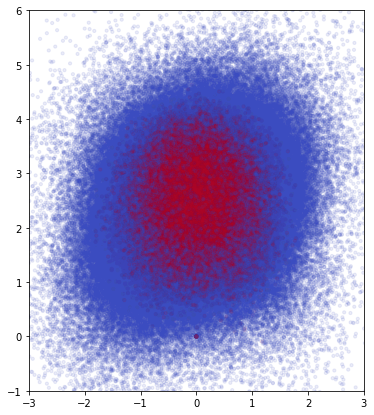

In [25]:
plt.figure(figsize=(6,7))
plt.scatter(final.plate_side, final.plate_height, s=10, alpha = 0.1, c=final.is_swing, cmap='coolwarm')
plt.xlim(-3,3)
plt.ylim(-1,6)

In [26]:
final[['pitch_id', 'is_swing']].to_csv('test_is_swing.csv', index=False)